# **Binned invariant mass fit with flarefly**

The goal of this tutorial is to provide an example of invariant mass fit using the package [flarefly](https://flarefly.github.io/flarefly/index.html).

This tutorial is based on the measurement of the invariant mass of the $\mathrm{B^{0}}$ meson, trough its two-body decay channel $\mathrm{B^{0}} \rightarrow \mathrm{D^{-}} +\mathrm{\pi^{+}}$, in the transverse-momentum interval $0 \leqslant p_{\mathrm{T}} \leqslant 50$ GeV/$c$. The data were Monte Carlo simulated by ALICE (where the decay channel of interest is forced) and correspond to 5 million minimum-bias pp collisions at $\sqrt{s}$ = 900 GeV. In this data sample about $12\,000$ $\mathrm{B^{0}}$ candidates were reconstructed.

## **Prerequisites**

To run the following code, you need to have [flarefly](https://flarefly.github.io/flarefly/index.html) installed. You can install it via pip:

In [1]:
%%capture
!pip install flarefly

## **File download**

In [2]:
%%capture
!curl -L https://github.com/flarefly/flarefly/raw/main/tutorials/histos_b0.root --output file.root

## **Required python packages**

The packages required for the tutorial are imported in the following.

In [3]:
%%capture
import numpy as np
import matplotlib.pyplot as plt
import uproot
from flarefly import DataHandler, F2MassFitter

## **Prepare data | DataHandler instance**

The data one aims at fitting are drawn from the histogram *hist_mass_bzero_pt0_50* contained in *file.root* downloaded earlier.

*flarefly* allows for a simple handling of the data by calling a *DataHandler* instance that shall take care of adapting the input to our fitter class.

**NB**: In our case the input data are _binned_ but *flarefly* can also handle _unbinned_ data.

In [4]:
data = DataHandler(data="file.root",
                   var_name=r"$M_\mathrm{D^{-}\pi^{+}}$ (GeV/$c^{2}$)",
                   histoname="hist_mass_bzero_pt0_50")

## **Prepare fitter | F2MassFitter instance**

Once data are prepared, one still needs to configure the fitter:

1. Define probability density functions (PDFs) for signal and background
2. Define a F2MassFitter instance
3. Initialize fit parameters

### **1. Define PDFs**

*flarefly* is based on *zfit*, itself optimised for a direct manipulation of probability density functions. Hence the need to define PDFs for signal and for background.

**NB**: *flarefly* allows one to perform multi-fits with several signal and/or background PDFs. That's why one works with PDFs **lists**. In this sense, every PDF is associated to an index (i.e. its position in the list). This index will be required later while configuring the fitter.

In [5]:
# define PDFs lists
signal_pdfs = ["gaussian"]
background_pdfs = ["expo"]

# define the ids
gaussian_id = 0 # because signal_pdfs[gaussian_id] = "gaussian"
expo_id = 0     # because background_pdfs[expo_id] = "expo"

### **2. Define a F2MassFitter instance**



In [6]:
fitter = F2MassFitter(data_handler=data,
                      name_signal_pdf=signal_pdfs,
                      name_background_pdf=background_pdfs,
                      name=f"{background_pdfs[expo_id]}_{signal_pdfs[gaussian_id]}")

**NB**: the name of the *F2MassFitter* instance is optional yet needed in case of multiple fitters defined in the same script (each fitter shall possess a unique name).

### **3. Initialize fit parameters**

The naming convention of the fit parameters is adapted to *flarefly* environment:

- First of all, one can access the parameters names either via the [_zfit_ documentation](https://zfit.readthedocs.io/en/latest/user_api/zfit.pdf.html) (for the PDFs defined there) or in the [_custom_pdfs_](https://flarefly.github.io/flarefly/custom_pdfs.html) class (for the PDFs specific to *flarefly*).
- Then, two subtelties arise:
  - Here *mass* takes a specific place among the fit parameters (as *flarefly* is thought for invariant mass fit) so there is a dedicated method for its initialization: _set_particle_mass_. \\
  Hence the _mu_ parameter (or _m_ for cauchy PDF) is handled via this dedicated method, where one can (among other possibilities) use the PDG code of the particle (511 for $\mathrm{B^0}$).
  - The normalization factor attached to each PDF, named _frac_ (for fraction of this PDF with respect to the total PDF) can also be initialized.

Otherwise, the other parameters of the PDFs (as _sigma_ for the gaussian PDF) keep the same name.

**NB**: one can limit the value of a parameter to a given interval or fix a given parameter, see [documentation](https://flarefly.github.io/flarefly/fitter.html#flarefly.fitter.F2MassFitter.set_signal_initpar).

In [7]:
fitter.set_particle_mass(gaussian_id, pdg_id=511)
fitter.set_signal_initpar(gaussian_id, "frac", 0.3, limits=[0.2, 0.4])
fitter.set_signal_initpar(gaussian_id, "sigma", 0.010)

fitter.set_background_initpar(expo_id, "lam", -1.5)

## **The actual (one-liner) mass fit**

The method _mass_zfit_ builds a total PDF (from the signal and background ones) to fit data using _zfit_ library.

In [8]:
fitter.mass_zfit()

INFO: Performing FIT
I MnSeedGenerator Computing seed using NumericalGradient calculator
I MnSeedGenerator Initial state: FCN =             10000 Edm =       2756.165993 NCalls =     17
I MnSeedGenerator Initial state  
  Minimum value : 10000
  Edm           : 2756.165993
  Internal parameters:	[ -2.775557562e-16      6.199583908     0.1417744688             -1.5]	
  Internal gradient  :	[      726.6872108       9316.26477     -19602.90312     -107.0612778]	
  Internal covariance matrix:
[[   0.0074602987              0              0              0]
 [              0  1.2811639e-06              0              0]
 [              0              0  1.7911082e-05              0]
 [              0              0              0   0.0079493442]]]
I VariableMetricBuilder Start iterating until Edm is < 0.001 with call limit = 680
I VariableMetricBuilder    0 - FCN =             10000 Edm =       2756.165993 NCalls =     17
I VariableMetricBuilder    1 - FCN =       8500.449712 Edm =       30.

FitResult of
<BinnedNLL model=[<zfit.models.tobinned.BinnedFromUnbinnedPDF object at 0x7c2eaf37e030>] data=[<zfit._data.binneddatav1.BinnedData object at 0x7c2c50346780>] constraints=[]> 
with
<Minuit Minuit, tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤══════════════════════════════╕
│  valid  │  converged  │  param at limit  │   edm   │   approx. fmin (full | opt.) │
╞═════════╪═════════════╪══════════════════╪═════════╪══════════════════════════════╡
│  True   │    True     │      False       │ 3.7e-06 │           381.54 |  8462.034 │
╘═════════╧═════════════╧══════════════════╧═════════╧══════════════════════════════╛

Parameters
name                           value  (rounded)        hesse    at limit
---------------------------  ------------------  -----------  ----------
expo_gaussian_frac_signal0             0.321056  +/-  0.0089       False
expo_gaussian_mu_signal0                5.27253  +/-  0.0014       False
expo_gaussian_sigma_signal0           0.04786

**NB**: one can directly store the fit result in a variable via *fitres = fitter.mass_zfit()* or call it later on as follows: *fitres = fitter.get_fit_result()*.

## **Draw plots**

*flarefly* provides plot utils to draw:
- the invariant mass fit of the total PDF, along with the signal PDF and background PDF. There is the possibility to plot _extra_info_ such as parameters, signal and background derived quantities;
- the raw residuals of the fit: (data_value - bkg_model_value);
- the standardized residuals of the fit: (data_value - bkg_model_value)/ sigma_data .

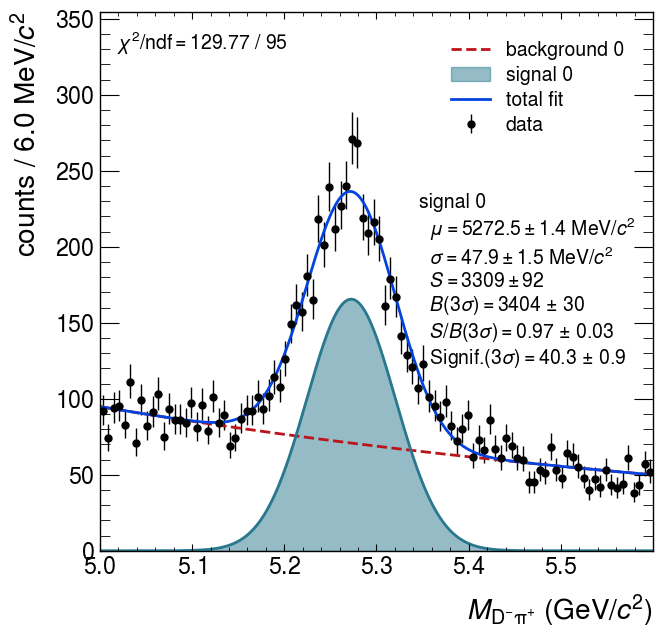

In [9]:
# plot the fit result with display options
plot_mass_fit = fitter.plot_mass_fit(style="ATLAS",
                    show_extra_info=True,
                    extra_info_loc=['upper left', 'center right'])

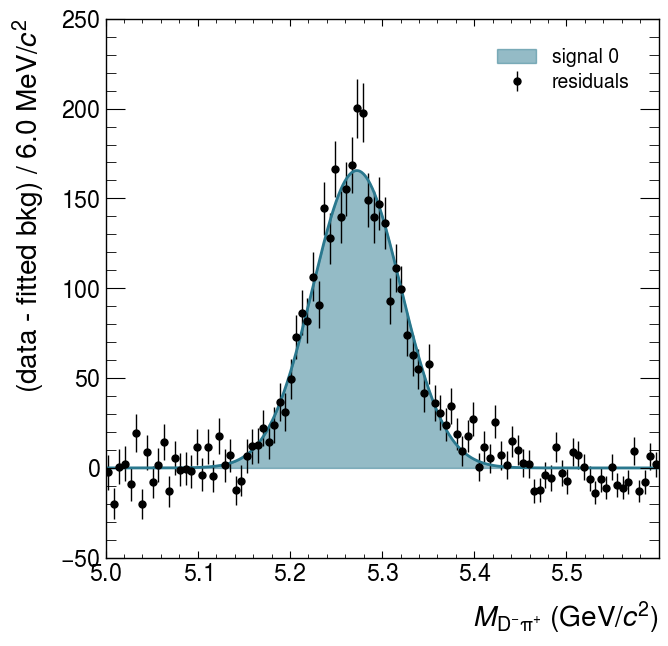

In [10]:
plot_raw_residuals = fitter.plot_raw_residuals(style="ATLAS")

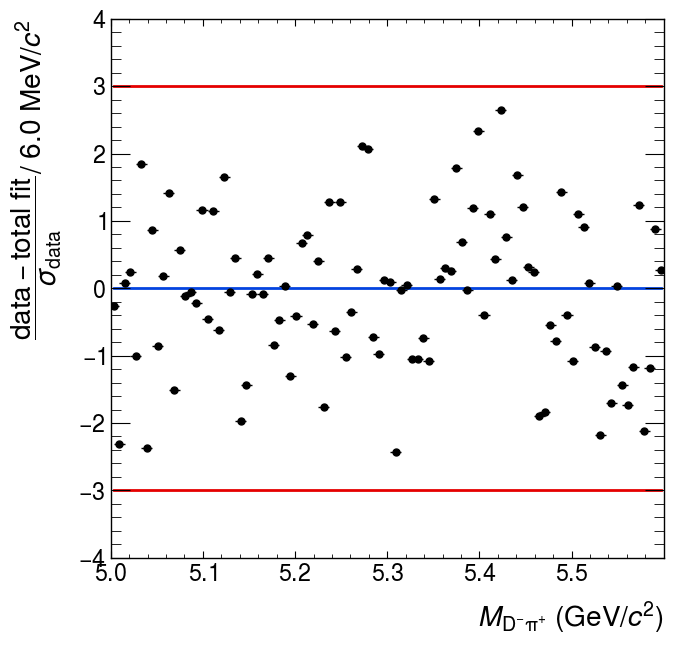

In [11]:
plot_std_residuals = fitter.plot_std_residuals(style="ATLAS")

## **Get information on fit results**

Once the mass fit is performed, one can access fit parameters value and uncertainty via _F2MassFitter_ instance.

In [12]:
frac_value, frac_error = fitter.get_signal_parameter(gaussian_id, "frac")
sigma_value, sigma_error = fitter.get_signal_parameter(gaussian_id, "sigma")

lambda_value, lambda_error = fitter.get_background_parameter(expo_id, "lam")

print(f"Signal fraction = {frac_value:.4f} +- {frac_error:.4f}")
print(f"sigma = {sigma_value:.4f} +- {sigma_error:.4f} GeV/c^2")
print(f"lambda = {lambda_value:.4f} +- {lambda_error:.4f} c^2/Gev")

Signal fraction = 0.3211 +- 0.0089
sigma = 0.0479 +- 0.0015 GeV/c^2
lambda = -1.0690 +- 0.0719 c^2/Gev


In HEP, one is also and foremost interested in accessing the raw yield of the studied particle. There is also a dedicated method for that.

In [13]:
raw_yield, raw_yield_error = fitter.get_raw_yield(gaussian_id)

print(f"B0 raw yield for 0 < pT < 50 GeV/c :{raw_yield:.0f} +- {raw_yield_error:.0f}")

B0 raw yield for 0 < pT < 50 GeV/c :3309 +- 92


## **Bonus: Export information to .root file**

One could be interested in saving the data and PDFs curves in a _.root_ file. If so, the method _dump_to_root_ can be used.

In [14]:
fitter.dump_to_root(filename="output.root")